# Plotting Suppl. CMV 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics

import warnings
import matplotlib as mpl
import plot_utils
import json
from scipy import stats

import logomaker as lm

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360
fliersize = 1

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
palette_tcrs = {'OTI': 'tab:green',
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick',
                'CMV': 'darkcyan'
               }
palette_tcrs_cmap = mpl.colors.ListedColormap(list(palette_tcrs.values()))

cmap_positions = mpl.colors.ListedColormap(['silver'] + sb.color_palette('Purples', 12)[3:])

cmap_heatmap = 'rocket'

color_base ='silver'
color_thresh = 'silver'
style_base = ':'
style_thresh = '--'

color_greedy = 'silver'
color_active = palette_tcrs['CMV']
color_random = 'grey'
color_cmv = palette_tcrs['CMV']

palette_active = {'Active': palette_tcrs['CMV'],
                  'Random': color_random,
                 }

palette_pos = sb.color_palette('Set3', 9)#[2:]
palette_pos = dict(zip([f'P{i}' for i in range(1, 11)], palette_pos))

In [6]:
palette_pos['P2'] = 'gold'

## Load Data

In [7]:
def read_cmv_data():
    path_in = '../data/Affinity_prediction_cmv.xlsx'
    sheet = 'Mean'
    df = pd.read_excel(path_in, sheet)
    
    df_pep = pd.read_excel(path_in, 'peptides',)
    df['Mutated_position'] = df_pep['Mutated Position']
    df['Mutated AA'] = df_pep['Amino acid']
    
    df['Mutated_position'] = df['Mutated_position'].replace({'NLVPMVATV': 0})
    df['Mutated AA'] = df['Mutated AA'].replace({'original': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Mutated_position', 'Mutated AA', 'Peptide_ID'])
    #tcrs = df.columns[4:11]
    #df = df[tcrs]
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    sorted_columns = df.loc['0_0'].sort_values(ascending=False)
    df = df[sorted_columns.index]
    return df
data_cmv_norm = read_cmv_data()

## Load Within Prediction Results

In [8]:
def compute_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['act'], g['pred']),
        'Pearson': g['act'].corr(g['pred'], method='pearson'),
        'Spearman': g['act'].corr(g['pred'], method='spearman'),
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all()
            else np.nan
        ),
        'Spearman_class': g['act'].corr(g['pred_prob'], method='spearman'),
    })

In [9]:
def load_perf_data():        
    path_in = '../activation-prediction/results'
    ppdf = pd.read_csv(f'{path_in}/NLVPMVATV_tcr_specific_data_size.csv.gz')    
    ppdf = ppdf[ppdf['normalization'] == 'none']

    # compute metric for each validation fold separately
    mdf = pd.concat([
        # except for lmo CV where each validation fold contained a single sample
        # in that case we just compute a global average for each tcr
        ppdf.query('features=="lmo"') \
            .groupby(['features', 'tcr']) \
            .apply(compute_metrics).reset_index(),
        ppdf.query('features!="lmo"') \
            .groupby(['features', 'tcr', 'fold']) \
            .apply(compute_metrics).reset_index(),
    ])
    mdf['features'] = mdf['features'].str.upper()

    lmdf = mdf.melt(
        id_vars=['tcr', 'features', 'fold'],
        value_vars=['R2', 'Pearson', 'Spearman', 'MAE', 'APS', 'AUC', 'Spearman_class'],
        var_name='Metric'
    ).rename(
        columns={'features': 'Split', 'value': 'Value'}
    )
    
    lmdf['Repertoire'] = 'CMV'
    ppdf['Repertoire'] = 'CMV'

    return ppdf, lmdf
ppdf, lmdf = load_perf_data()

C:\Users\felix.drost\Anaconda3\envs\mutagenesis\lib\site-packages\scipy\stats\stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [10]:
lmdf.groupby(['Split', 'Metric'])['Repertoire'].value_counts()

Split  Metric          Repertoire
L10O   APS             CMV           200
       AUC             CMV           200
       MAE             CMV           200
       Pearson         CMV           200
       R2              CMV           200
                                    ... 
LPO    MAE             CMV           180
       Pearson         CMV           180
       R2              CMV           180
       Spearman        CMV           180
       Spearman_class  CMV           180
Name: Repertoire, Length: 63, dtype: int64

In [11]:
lmdf[lmdf['Split']=='LMO'].groupby('Metric')['Repertoire'].value_counts()

Metric          Repertoire
APS             CMV           20
AUC             CMV           20
MAE             CMV           20
Pearson         CMV           20
R2              CMV           20
Spearman        CMV           20
Spearman_class  CMV           20
Name: Repertoire, dtype: int64

## Load Active Learning results

In [12]:
def load_experiment(filename):
    path_exp = f'../activation-prediction/results/active_learning/{filename}'
    with open(path_exp) as f:
        results_exp = json.load(f)
    return results_exp

In [13]:
results_within_cmv = {
    'Active': load_experiment('within/NLVPMVATV_FULL_act_avg_8.json'),
    'Random': load_experiment('within/NLVPMVATV_FULL_rdm_8.json'),
}

In [14]:
def get_mutation(apl, base):
    for i, (l1, l2) in enumerate(zip(apl, base)):
        if l1 != l2:
            return i+1, l1
    return '-', 'None'
    
def load_used_apls(filename):
    path_apls = f'../activation-prediction/results/active_learning/{filename}'
    base_epitope = 'SIINFEKL' if 'SIINFEKL' in filename else 'NLVPMVATV'
    
    df_apls = pd.read_csv(path_apls, skiprows = 1,header = None)
    columns = ['seed', 'tcr'] + list(range(1, len(df_apls.columns)-1))
    df_apls.columns = columns
    df_apls[1] = df_apls[1].str[1:]
    df_apls[columns[-1]] = df_apls[columns[-1]].str[:-1]
    
    if 'within' in filename:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 81))]
    else:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 80))]
    
    for col in df_apls.columns:
        if col in ['seed', 'tcr']:
            continue
        df_apls[col] = df_apls[col].str.strip().str[1:-1]
        df_apls[f'pos_{col}'], df_apls[f'aa_{col}'] = zip(*df_apls[col].apply(lambda x: get_mutation(x, base_epitope)))        
    return df_apls

In [15]:
apls_within_cmv = {
    'Active': load_used_apls('within/NLVPMVATV_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/NLVPMVATV_selectedAPLs_add_by_random.csv'),
}

## Loading motif

In [16]:
def read_mhc_motifs(hla, length):
    path_data = '../data'
    df_mhc = pd.read_csv(f'{path_data}/data_classI_MS_Peptides_{hla}.txt', header=None)
    df_mhc = df_mhc[df_mhc[0].str.len() == length]
    print(len(df_mhc))
    df_mhc = df_mhc[0].apply(lambda x: pd.Series(list(x)))
    df_mhc.columns = [el for el in df_mhc.columns]
    df_mhc = df_mhc.apply(pd.value_counts).transpose() / len(df_mhc)
    df_mhc = df_mhc.fillna(0.0)
    df_mhc = lm.transform_matrix(df_mhc, from_type='probability', to_type='information')
    return df_mhc

df_mhc = read_mhc_motifs('A0201', 9)
dfs_mhc = {
    'HLA-A02*01': df_mhc,
}

anchor_positions = {
    'H2-Kb': [3, 5, 8],
    'HLA-A02*01': [2, 9],
    'HLA-B07*02': [2, 9],
}
epitopes = {
    'H2-Kb': 'SIINFEKL',
    'HLA-A02*01': 'NLVPMVATV',
    'HLA-B07*02': 'VPSVWRSSL',
}

8372


## Plotting functions - Data

In [17]:
def plot_activation_heatmap(data, gs_full, fig):
    data = data.transpose()       
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                              nrows=2, ncols=1, 
                                              height_ratios=[0.06+1, 0.1],
                                              hspace=0.1)
    
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                              nrows=2, ncols=1, 
                                              width_ratios=[1], 
                                              height_ratios=[0.06, 1],
                                              wspace=0.01, hspace=0.02)
    
    cbar_width = 0.75
    gs_3 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[1],
                                              nrows=1, ncols=3, 
                                              width_ratios=[(1-cbar_width)/2, cbar_width, (1-cbar_width)/2],
                                              wspace=0.01)
    # apl annotation
    ax_colcolors = fig.add_subplot(gs[0])
    apl_colors = np.array([int(apl.split('_')[0]) for apl in data.columns]).reshape((1, -1))
    
    apl_labels = [''] * len(data.columns)
    idx_start = 0
    for i in list(set(apl_colors.tolist()[0]))[1:] + [0]:
        n_elements = np.sum(apl_colors==i)
        apl_labels[idx_start + n_elements//2] = f'P{i}' if i != 0 else ''
        idx_start += n_elements
            
    cmap = [i for l, i in palette_pos.items()] + ['black']

    apl_colors[apl_colors == 0] = 10
    apl_colors = [[i-1 for i in apl_colors[0]]]
    sb.heatmap(apl_colors, ax=ax_colcolors, cbar=False, yticklabels=False,
              vmin=0, vmax=9, cmap=cmap, xticklabels=apl_labels,
              )
    ax_colcolors.set_xticklabels(apl_labels, rotation=0)
    ax_colcolors.xaxis.tick_top()
    ax_colcolors.tick_params(axis='x', length=0, pad=0)
    ax_colcolors.set_title('APLs', pad=3)

    # heatmap
    ax_main = fig.add_subplot(gs[1])
    ax_cbar = fig.add_subplot(gs_3[1])
    plot = sb.heatmap(data, ax=ax_main, cbar_ax=ax_cbar, cmap=cmap_heatmap,
                      cbar_kws={'label': 'Activation score (%)', "orientation": "horizontal", 'pad': 0.1})
    
    plot.tick_params(axis='y', length=0, pad=1)

    plot.set_yticklabels([])#plot.get_yticklabels(), rotation=0)
    plot.set_ylabel('TCR')
    plot.set_xticks([])

    ax_main.grid(False)
    sb.despine(ax=ax_main, top=True, right=True, left=True, bottom=True)

In [18]:
def plot_tcrs_averaged(data_long, gs_full, xlabel='Activation Score (%)', fig=None):
    gs_12 = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_full,
                                          nrows=2, ncols=1, 
                                          height_ratios=[0.06+1, 0.1],
                                          hspace=0.1)
    gs = mpl.gridspec.GridSpecFromSubplotSpec(subplot_spec=gs_12[0],
                                          nrows=2, ncols=1,
                                          height_ratios=[0.06, 1],
                                          hspace=0.02)
    ax = fig.add_subplot(gs[1])
    
    data = data_long.copy()
    data = data.melt(ignore_index=False)
    data = data.reset_index()
    data = data.rename(columns={'variable': 'TCR', 'value': 'Activation', 'index': 'Epitope'})

    data['cat'] = 'CMV'

    plot = sb.barplot(data=data, x='Activation', y='TCR', hue='cat', palette=palette_tcrs,
                       dodge=False, errwidth=0.5, ci='sd', orient='h', capsize=0.45,
                       ax=ax)

    ax.set_xlim(left=0)
    ax.set_yticklabels([])
    plot.set_xlabel(xlabel, labelpad=2)
    plot.tick_params(axis='both', length=0, pad=3)
    plot.set_ylabel('TCR', labelpad=2)
    plot.get_legend().remove()  
    ax.grid(False)
    sb.despine(ax=ax)
    return ax

In [19]:
def plot_epitopes(data, ax, ylabel='Activation Score (%)', base_epitope='SIINFEKL', threshold=46.9, do_legend=False):
    # columns = [x for x in data.columns if x.startswith('Ed') or x.startswith('R')]
    # data = data[columns]
    data['Activation'] = np.mean(data.values, axis=1)
    data = data[['Activation']]
    data['Mutated position'] = data.index.str.split('_').str[0].astype(int)
    data['Mutated position'] = data['Mutated position'].apply(lambda x: f'P{x}')
    activation_base = data.iloc[-1]['Activation']
    data = data[:-1]
        
    plot = sb.swarmplot(data=data, y='Activation', x='Mutated position', s=2,
                         hue='Mutated position', palette=palette_pos, dodge=False, ax=ax)
    plot.set_ylabel(ylabel, labelpad=2)
    plot.set_xlabel(plot.get_xlabel(), labelpad=2)
    plot.tick_params(axis='both', length=0, pad=3)

    line_base = plot.axhline(activation_base, color=color_base, linestyle=style_base)
    if threshold:
        line_thresh = plot.axhline(threshold, color=color_thresh, linestyle=style_thresh)

    if not do_legend:
        plot.get_legend().remove()
    else:
        handles = [line_base, line_thresh] if threshold else [line_base]
        names =  ['Wild-type', 'Threshold'] if threshold else ['Wild-type']
        plot.legend(handles, names, ncol=2,
                    bbox_to_anchor=(0.5, 1.2), loc='upper center', frameon=True)
  
    ax.grid(False)
    sb.despine(ax=ax)

## Plotting - Within Prediction

In [20]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.query('features == "lmo"').groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])
        
    ax.tick_params(axis='both', length=0, pad=3)
    
    df_mean = lmdf[lmdf['tcr'].isin(data['tcr'])]
    df_mean = df_mean[df_mean['Split']=='LMO']
    mean = df_mean[df_mean['Metric']==metric_name]['Value'].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    
    sb.despine(ax=ax)

In [21]:
order_metrics = ['AUC', 'APS', 'Spearman']
def plot_metric_boxplot(metrics, ax):        
    bp_data = lmdf.query('Split == "LMO"')
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax,
        x='Metric', order=order_metrics,
        hue_order=['CMV'], palette=palette_tcrs,
        fliersize=fliersize,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel('', labelpad=0)
    ax.legend().remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.tick_params(axis='both', length=0, pad=3)

In [22]:
def plot_feature_tests(ax, metric='Spearman', do_legend=False):
    data_feats = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_feats = data_feats[data_feats['Split'].isin(['LMO', 'LPO', 'LAO'])]
    
    plot = sb.boxplot(data=data_feats, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax,
                     hue_order=['CMV'], fliersize=fliersize,
                     order=['LMO', 'LPO', 'LAO'])
    
    ax.set_xlabel('', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    if not do_legend:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0., 1.25), loc="upper center", ncol=4, frameon=True)
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [23]:
def plot_data_size(ax, metric='Spearman'):
    data_size = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_size = data_size[~data_size['Split'].isin(['LMO', 'LPO', 'LAO'])]
    data_size = data_size.replace({'Split': {
        f'L{p}O': f'{100 - p}%' for p in [10, 25, 50, 75, 90, 95]
    }})
    
    plot = sb.lineplot(data=data_size, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax)
    
    ax.set_xlabel('Amount of training data', labelpad=0)
    ax.set_ylabel(metric, labelpad=2)
    
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

## Plotting - Active

In [24]:
def plot_performance(data, metric, methods, ax=None, xticks=None, legend=False, active_color=None):
    dfs_results = []
    for method in methods:
        df = pd.DataFrame(data[method][metric])
        columns = ['tcr', 'educated', 'iteration', metric] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    
    #threshold = 0.7 if metric == 'Spearman' else 0.85
    #ax.axhline(threshold, linestyle='dashed', color='lightgray', linewidth=1)
    
    #x_thresh = 2
    #ax.axvline(x_thresh, linestyle='dashed', color='lightgray', linewidth=1)
    
    colors = {
        'Greedy_auc': color_greedy,
        'Greedy_spearman': color_greedy,
        'Active': color_active if active_color is None else active_color,
        'Random': color_random,
    }
    
    plot = sb.lineplot(data=df_joint, x='iteration', y=metric, hue='method', ax=ax, palette=colors)


    sb.despine(bottom=False, left=False)

    plot.set_xlabel('Training Samples', labelpad=1)
    plot.set_ylabel(metric.upper() if len(metric)<4 else metric, labelpad=1)
    

    if legend:
        legend_elements = [mpl.lines.Line2D([0], [0], label=name, color=color)
                          for name, color in palette_active.items()]
        ax.legend(handles=legend_elements, title=None, bbox_to_anchor=(-0.25, 1.2), 
                  loc="upper center", ncol=3, frameon=True)
    else:
        ax.get_legend().remove()
    plot.set_xticks(list(range(len(xticks))))
    plot.set_xticklabels(xticks, size='small')
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [25]:
def plot_n_vs_metric(metric, ax):
    tmp = lmdf[(lmdf['Split']=='LMO') & (lmdf['Metric'].isin(['APS', 'AUC', 'Spearman']))
            ][['tcr', 'Metric', 'Value']].pivot(columns='Metric', index='tcr').sort_values('tcr').round(3)
    num_act = pd.DataFrame((data_cmv_norm>40.0).sum(axis=0), columns=['#Activation'])[:-1]
    num_act.index = 'TCR' + num_act.index.str.replace('_', '-')
    tmp.columns = tmp.columns.droplevel(0)
    tmp = pd.concat([tmp, num_act], axis=1)
    sb.scatterplot(data=tmp, y=metric, x='#Activation', color=palette_tcrs['CMV'], ax=ax, s=10)
    sb.regplot(data=tmp, y=metric, x='#Activation', color='gray', ax=ax, scatter=False, line_kws={'zorder': -1, 'linewidth':1})
    ax.set_xlim((tmp['#Activation'].min()-3, tmp['#Activation'].max()+3))
    
    ax.set_xlabel('Activated APLs', labelpad=1)
    ax.set_ylabel(metric, labelpad=1)
    ax.tick_params(axis='both', length=0, pad=3)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [26]:
def plot_legend(ax):
    legend_elements = [mpl.patches.Patch(facecolor=color, edgecolor=color, label=name)
                      for name, color in palette_pos.items() if name!='P2']
    ax.legend(handles=legend_elements, #ncol=9, 
              loc='upper right', bbox_to_anchor=(1.25, 1.), frameon=True,
              title='Epitope\nPosition')

## Motif

In [27]:
title_map = {
    'H2-Kb': 'H-2K$^{b}$', 
    'HLA-B07*02': 'HLA-B*07:02', 
    'HLA-A02*01': 'HLA-A*02:01'
}
def plot_motif(mhc, ax):
    df = dfs_mhc[mhc].copy()   
    logo = lm.Logo(df, stack_order='big_on_top', color_scheme='chemistry', font_name='Arial Rounded MT Bold', ax=ax, )
    
    for p in anchor_positions[mhc]:
        logo.highlight_position_range(pmin=p-1, pmax=p-1, color='cornsilk')
    sb.despine(ax=ax)
    ax.set_ylabel('Bits', labelpad=1)
    ax.set_xlabel('', labelpad=0)
    logo.ax.set_xticks(range(df.shape[0]))
    logo.ax.set_xticklabels([f'P{i+1}' for i in range(df.shape[0])])
    ax.grid(False)
    ax.tick_params(axis='both', length=0, pad=3)
    
    epitope = epitopes[mhc]
    ax2 = ax.twiny()
    ax2.set_xticks([(i+0.5)-i/len(epitope) for i in range(len(epitope))])  
    ax2.set_xticklabels([l for l in epitope])
    ax2.tick_params(axis='x', which='both', bottom=False, top=True)
    sb.despine(ax=ax2)
    ax2.grid(False)
    ax2.tick_params(axis='x', length=0, pad=0)
    ax2.set_xlim(0, len(epitope)-1)

## Fig. 5

<ipython-input-19-7370800b489d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mutated position'] = data.index.str.split('_').str[0].astype(int)
<ipython-input-19-7370800b489d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mutated position'] = data['Mutated position'].apply(lambda x: f'P{x}')


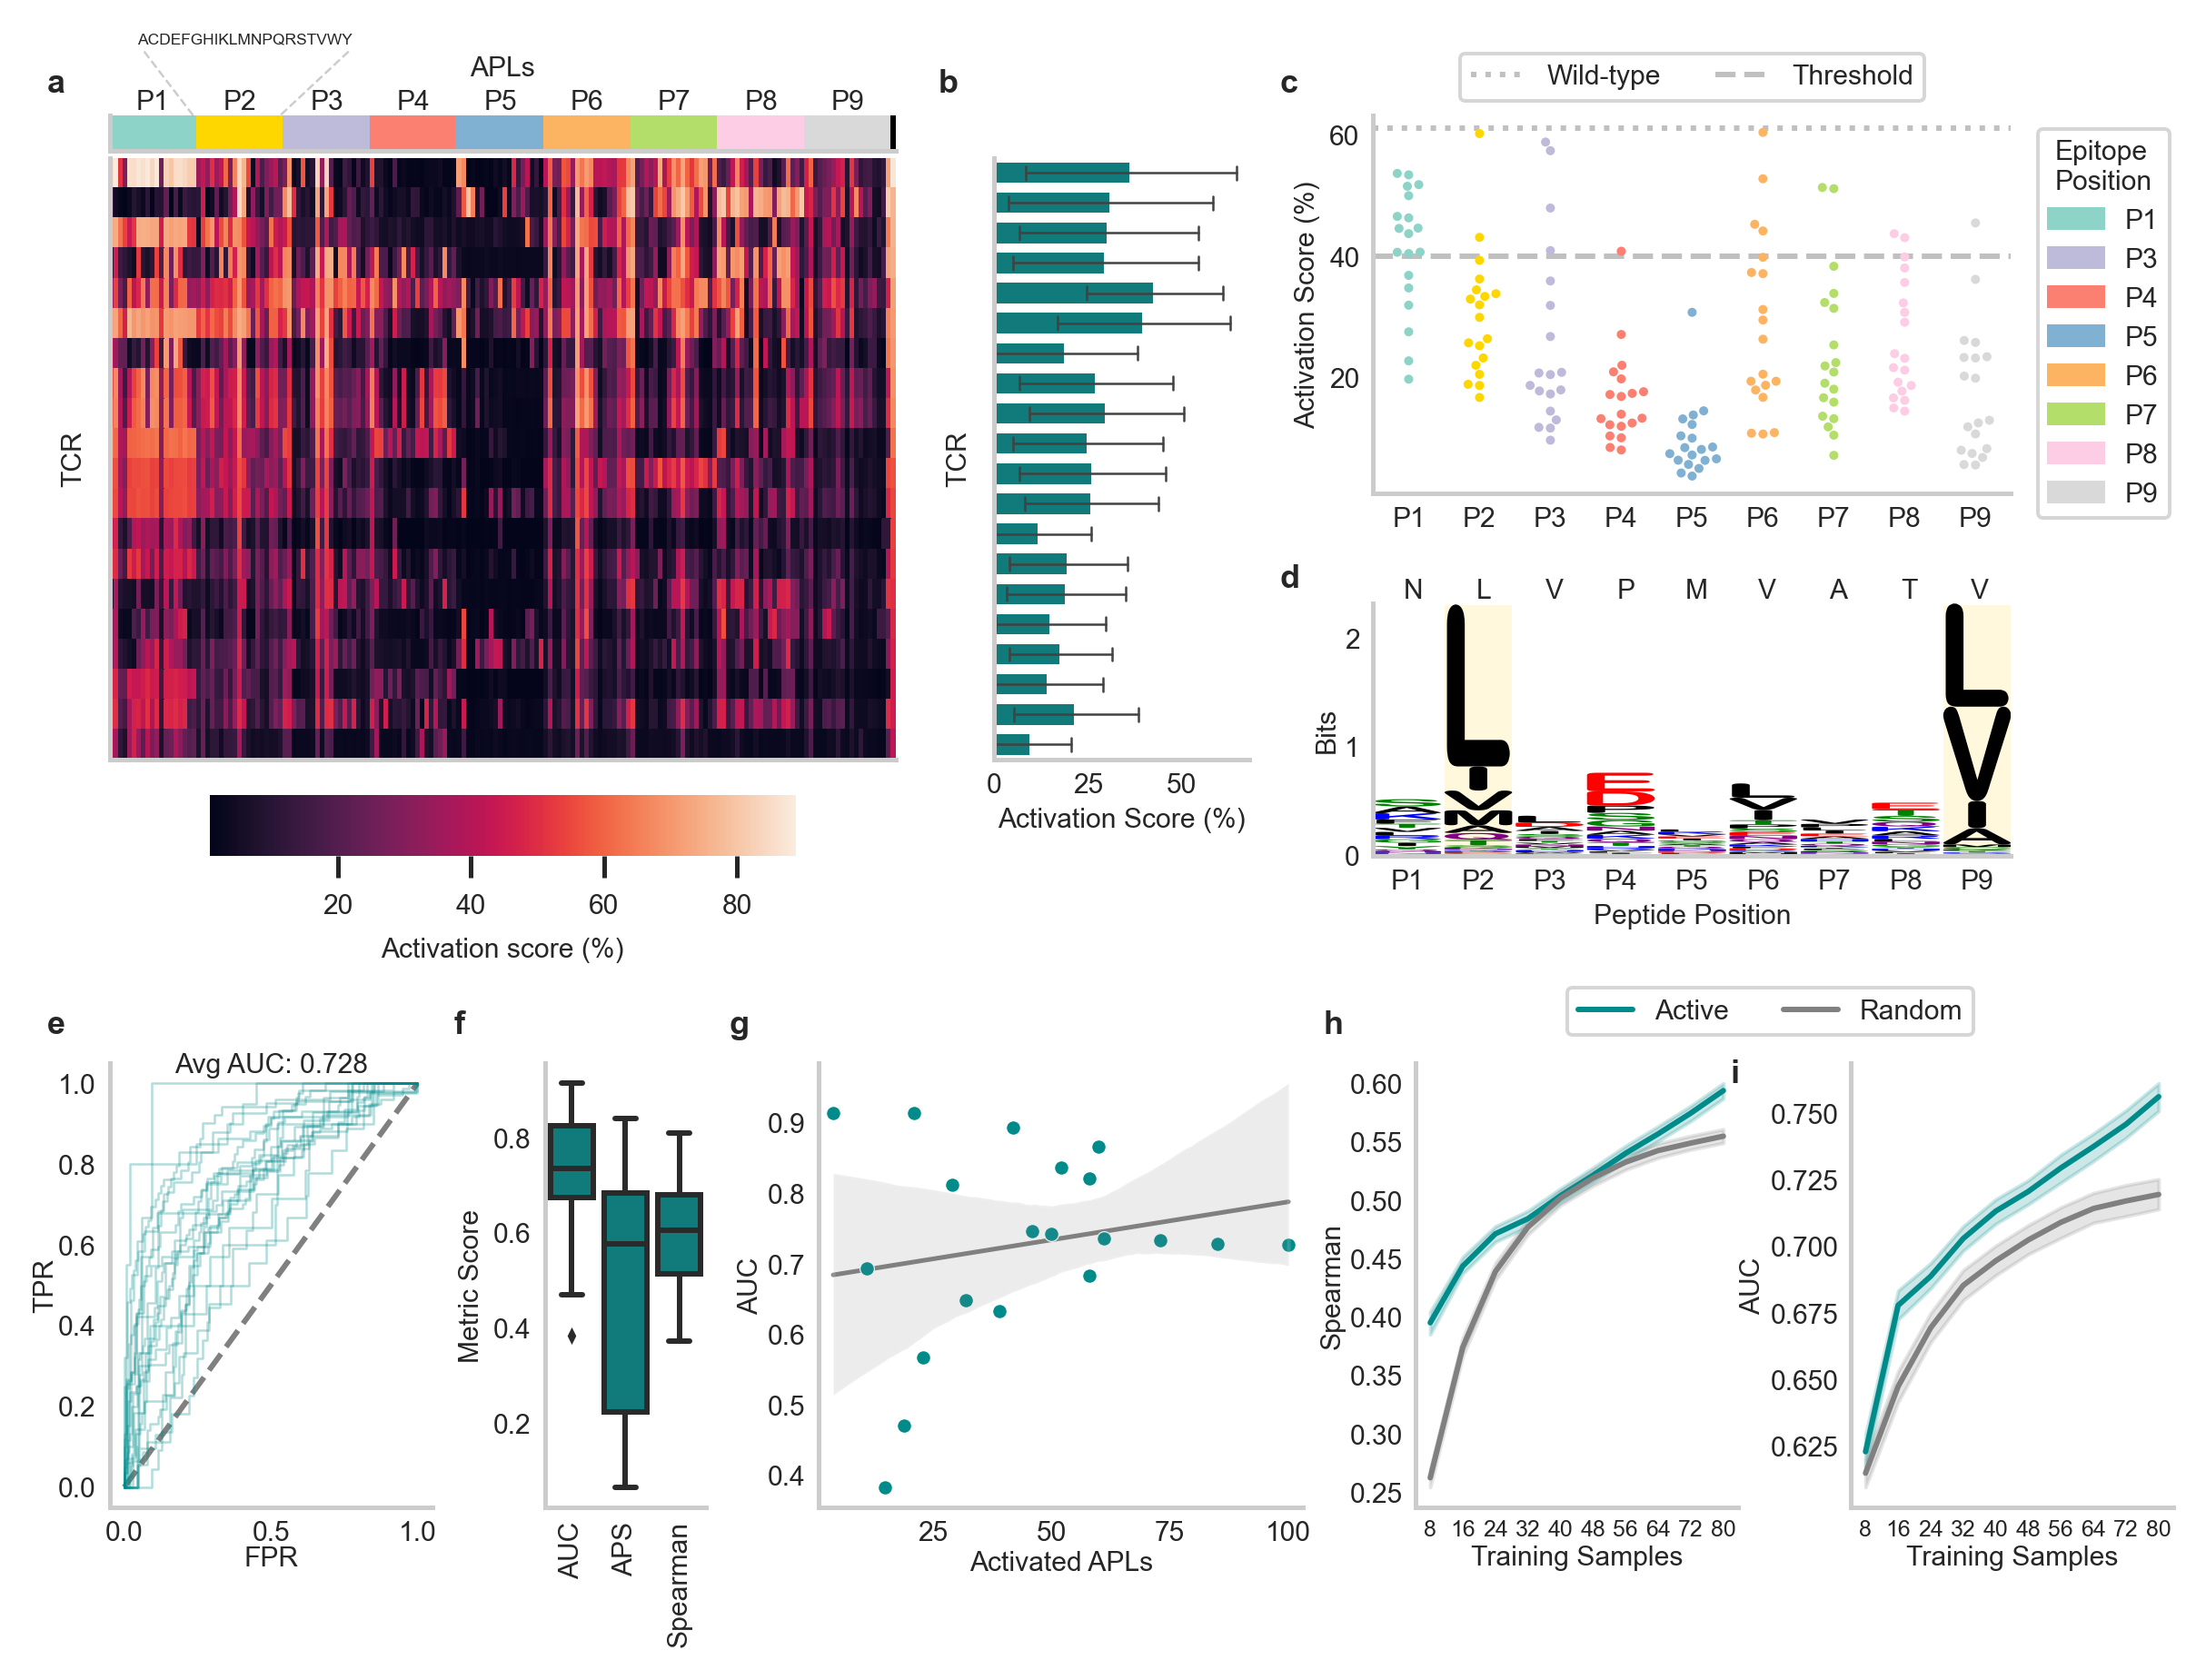

In [28]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.75), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-9'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[0.5, 0.3],
    width_ratios=[1],
    #hspace=0.4
)

gridspecs['gs_1234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-9'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.1,
    #hspace=0.25,
)

gridspecs['gs_2-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][1],
    nrows=1,
    ncols=3,
    height_ratios=[1, ],
    width_ratios=[2, 5, 0.3],
    wspace=0.4,
    #hspace=0.25,
)

gridspecs['gs_3'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_2-4'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1.5, 1],
    width_ratios=[1],
    hspace=0.35
)

gridspecs['gs_4-9'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-9'][1],
    nrows=1,
    ncols=5,
    height_ratios=[1],
    width_ratios=[1, 0.5, 1.5, 1, 1],
    wspace=0.35,
)

axes['ax_c'] = fig.add_subplot(gridspecs['gs_3'][0])
axes['ax_c2'] = fig.add_subplot(gridspecs['gs_3'][1])
axes['ax_legend'] = fig.add_subplot(gridspecs['gs_2-4'][2])
axes['ax_legend'].axis('off')

plot_activation_heatmap(data_cmv_norm, gridspecs['gs_1234'][0], fig)
axes['ax_b'] = plot_tcrs_averaged(data_cmv_norm, gridspecs['gs_2-4'][0], fig=fig)

plot_epitopes(data_cmv_norm, axes['ax_c'], do_legend=True, base_epitope='NLVPMVATV', threshold=40.0)
axes['ax_c'].set_xlabel(None)
plot_motif('HLA-A02*01', axes['ax_c2'])
axes['ax_c2'].set_xlabel('Peptide Position', labelpad=2)

plot_legend(axes['ax_legend'])

d = 0.04
fig.text(0.061, 0.95+d, 'ACDEFGHIKLMNPQRSTVWY', size='xx-small')
line_left = mpl.lines.Line2D([0.064, 0.087], [0.945+d, 0.905+d], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
line_right = mpl.lines.Line2D([0.157, 0.1249], [0.945+d, 0.905+d], linestyle='dashed', linewidth=0.5, color='gray', alpha=0.4)
fig.add_artist(line_left)
fig.add_artist(line_right)


axes['ax_d'] = fig.add_subplot(gridspecs['gs_4-9'][0])
axes['ax_e'] = fig.add_subplot(gridspecs['gs_4-9'][1])

plot_auc(ppdf[ppdf['Repertoire']=='CMV'], axes['ax_d'], xlabel='FPR', ylabel='TPR')
plot_metric_boxplot(['Spearman', 'AUC', 'APS'], axes['ax_e'])


axes['ax_f'] = fig.add_subplot(gridspecs['gs_4-9'][2])
axes['ax_g'] = fig.add_subplot(gridspecs['gs_4-9'][3])
axes['ax_h'] = fig.add_subplot(gridspecs['gs_4-9'][4])

groups = [i//8 for i in range(80)]
xticks = [8+8*i for i in range(10)]

plot_n_vs_metric('AUC', ax=axes['ax_f'])

plot_performance(results_within_cmv, 'Spearman', ['Active', 'Random'], ax=axes['ax_g'], xticks=xticks)
plot_performance(results_within_cmv, 'auc', ['Active', 'Random'], ax=axes['ax_h'], xticks=xticks, 
                 legend=True)


fig.text(0.02, 0.96, 'a', size='large', weight='bold')
fig.text(0.425, 0.96, 'b', size='large', weight='bold')
fig.text(0.58, 0.96, 'c', size='large', weight='bold')
fig.text(0.58, 0.66, 'd', size='large', weight='bold')

fig.text(0.02, 0.39, 'e', size='large', weight='bold')
fig.text(0.205, 0.39, 'f', size='large', weight='bold')
fig.text(0.33, 0.39, 'g', size='large', weight='bold')
fig.text(0.60, 0.39, 'h', size='large', weight='bold')
fig.text(0.785, 0.36, 'i', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig_cmv1.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_fig_cmv1.png', dpi=DPI, bbox_inches='tight')

## Paper numbers

In [29]:
(data_cmv_norm[:-1] > 40.0).sum()

77_14         72
81_14         57
65_8          59
73_14         57
6_2           99
5_2           84
83_3          22
10_4          49
11_4          60
82_14         41
84_3          51
66_8          45
3_4           10
54_10         28
52_10         31
1_4           14
74_14         18
4_4           20
2_4           38
51_10          3
Activation    29
dtype: int64

In [30]:
df_tmp = (data_cmv_norm>40)
df_tmp['pos'] = df_tmp.index.str[0]
df_tmp.groupby('pos').sum()

,77_14,81_14,65_8,73_14,6_2,5_2,83_3,10_4,11_4,82_14,...,66_8,3_4,54_10,52_10,1_4,74_14,4_4,2_4,51_10,Activation
pos,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,17,0,19,6,12,19,5,11,13,16,...,17,4,13,2,2,4,16,12,3,13
2,9,3,14,8,14,16,2,12,13,4,...,7,1,1,2,1,1,1,2,0,2
3,4,6,3,9,16,10,3,5,5,5,...,4,2,5,6,2,3,2,7,0,4
4,1,0,0,5,8,2,0,6,8,11,...,1,1,2,3,0,0,0,4,0,1
5,4,4,1,0,5,5,1,0,0,0,...,1,0,0,0,1,4,0,1,0,0
6,13,8,12,6,8,12,3,6,7,1,...,6,2,5,4,2,2,1,3,0,4
7,13,11,3,7,15,9,3,3,4,0,...,2,0,2,4,1,1,0,2,0,2
8,5,17,4,13,12,6,4,2,5,4,...,6,0,0,9,4,3,0,6,0,2


### Prediction

In [31]:
pd.set_option('display.expand_frame_repr', False)
print('---  summary statistics\n',
      lmdf.query('Split=="LMO"') \
          .groupby(['Metric', 'Repertoire'])['Value'].describe())

---  summary statistics
                            count       mean       std       min       25%        50%        75%        max
Metric         Repertoire                                                                                 
APS            CMV          20.0   0.488752  0.269935  0.065446  0.224109   0.576429   0.684258   0.840255
AUC            CMV          20.0   0.727530  0.140213  0.383076  0.674475   0.734869   0.824968   0.914073
MAE            CMV          20.0  11.508998  3.377754  5.188202  9.347489  11.479430  13.604764  17.688774
Pearson        CMV          20.0   0.563017  0.157544  0.254370  0.439033   0.568154   0.664670   0.792444
R2             CMV          20.0   0.331878  0.178510  0.034044  0.180715   0.320128   0.439457   0.627679
Spearman       CMV          20.0   0.592091  0.129714  0.371903  0.513280   0.605453   0.679311   0.809617
Spearman_class CMV          20.0   0.481882  0.141202  0.244362  0.374811   0.485333   0.581557   0.724589


In [32]:
lmdf.query('Metric=="Spearman"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric    Repertoire  Split
Spearman  CMV         L10O     0.563665
                      L25O     0.583167
                      L50O     0.567073
                      L75O     0.522563
                      L90O     0.359962
                      L95O     0.263797
                      LAO      0.614396
                      LMO      0.592091
                      LPO      0.214551
Name: Value, dtype: float64

In [33]:
lmdf.query('Metric=="AUC"').groupby(['Metric', 'Repertoire', 'Split'])['Value'].mean()

Metric  Repertoire  Split
AUC     CMV         L10O     0.733977
                    L25O     0.728980
                    L50O     0.728768
                    L75O     0.704230
                    L90O     0.636898
                    L95O     0.595632
                    LAO      0.779214
                    LMO      0.727530
                    LPO      0.633424
Name: Value, dtype: float64

In [34]:
print('---  CMV\n')
print(lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="CMV"') \
      .sort_values('Value', ascending=False))
print()
print(lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="CMV"') \
      .sort_values('Value', ascending=False))

---  CMV

           tcr Split  fold Metric     Value Repertoire
9005    TCR4-4   LMO   NaN    AUC  0.914073        CMV
9007  TCR51-10   LMO   NaN    AUC  0.913690        CMV
9017  TCR82-14   LMO   NaN    AUC  0.893058        CMV
9011   TCR65-8   LMO   NaN    AUC  0.866525        CMV
9019   TCR84-3   LMO   NaN    AUC  0.837500        CMV
9016  TCR81-14   LMO   NaN    AUC  0.820791        CMV
9009  TCR54-10   LMO   NaN    AUC  0.812188        CMV
9012   TCR66-8   LMO   NaN    AUC  0.746384        CMV
9001   TCR10-4   LMO   NaN    AUC  0.742138        CMV
9002   TCR11-4   LMO   NaN    AUC  0.735661        CMV
9015  TCR77-14   LMO   NaN    AUC  0.734077        CMV
9006    TCR5-2   LMO   NaN    AUC  0.727696        CMV
9010    TCR6-2   LMO   NaN    AUC  0.726852        CMV
9004    TCR3-4   LMO   NaN    AUC  0.694410        CMV
9013  TCR73-14   LMO   NaN    AUC  0.682902        CMV
9008  TCR52-10   LMO   NaN    AUC  0.649194        CMV
9003    TCR2-4   LMO   NaN    AUC  0.633162        CMV


In [35]:
print('---  spearman by position averaging spearman of individual tcrs\n',
      ppdf.query('features=="lpo"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by position averaging spearman of individual tcrs
             rho         p
count  9.000000  9.000000
mean   0.214551  0.321389
std    0.211846  0.165787
min   -0.083124  0.140416
25%    0.042164  0.176997
50%    0.309413  0.253031
75%    0.403796  0.470132
max    0.443562  0.538791


In [36]:
print('---  spearman by amino acid averaging spearman of individual tcrs\n',
      ppdf.query('features=="lao"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by amino acid averaging spearman of individual tcrs
              rho          p
count  20.000000  20.000000
mean    0.614396   0.158667
std     0.099136   0.091957
min     0.393613   0.041469
25%     0.582353   0.095750
50%     0.633333   0.151166
75%     0.670851   0.176450
max     0.740833   0.396916


In [37]:
# t-test to find significance of split performance reduction
print('---  data size hypothesis testing')

for m in ['Spearman', 'AUC']:
    print(m)
    lmdf.query(f'Metric == "{m}"').groupby(['Split', 'tcr'])['Value'].mean().reset_index()

    for r in ['CMV']:
        print(f'---- {r}')
        lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        for split in lmdf['Split'].unique():
            if split == 'LMO':
                continue

            split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
            lmo_aps = lmo_aps.loc[split_aps.index]
            assert np.all(lmo_aps.index == split_aps.index)
            tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
            md = split_aps.mean() - lmo_aps.mean()
            sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

            print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print(f'---- all')
    lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
    for split in lmdf['Split'].unique():
        if split == 'LMO':
            continue

        split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        lmo_aps = lmo_aps.loc[split_aps.index]
        assert np.all(lmo_aps.index == split_aps.index)
        tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
        md = split_aps.mean() - lmo_aps.mean()
        sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

        print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print('')
    print('---')

---  data size hypothesis testing
Spearman
---- CMV
split L10O vs. LMO - mean difference -0.0284 - effect size -0.2035 - W: 149.0000 , p: 5.270e-02
split L25O vs. LMO - mean difference -0.0089 - effect size -0.0686 - W: 141.0000 , p: 9.467e-02
split L50O vs. LMO - mean difference -0.0250 - effect size -0.1893 - W: 197.0000 , p: 8.392e-05
split L75O vs. LMO - mean difference -0.0695 - effect size -0.5076 - W: 209.0000 , p: 1.907e-06
split L90O vs. LMO - mean difference -0.2321 - effect size -1.7492 - W: 210.0000 , p: 9.537e-07
split L95O vs. LMO - mean difference -0.3283 - effect size -2.6427 - W: 210.0000 , p: 9.537e-07
split LAO vs. LMO - mean difference 0.0223 - effect size 0.1689 - W: 47.0000 , p: 9.867e-01
split LPO vs. LMO - mean difference -0.3775 - effect size -3.3303 - W: 210.0000 , p: 9.537e-07
---- all
split L10O vs. LMO - mean difference -0.0284 - effect size -0.2035 - W: 149.0000 , p: 5.270e-02
split L25O vs. LMO - mean difference -0.0089 - effect size -0.0686 - W: 141.0000

In [38]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

Spearman of LPO: 
   Repertoire     Value
0        CMV  0.214551

AUC of LPO: 
   Repertoire     Value
0        CMV  0.633424


In [39]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"')['Value'].mean())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"')['Value'].mean())

Spearman of LPO: 
 0.21455144054341727

AUC of LPO: 
 0.6334235295451118


In [40]:
(data_cmv_norm[:-1] > 40.0).sum()

77_14         72
81_14         57
65_8          59
73_14         57
6_2           99
5_2           84
83_3          22
10_4          49
11_4          60
82_14         41
84_3          51
66_8          45
3_4           10
54_10         28
52_10         31
1_4           14
74_14         18
4_4           20
2_4           38
51_10          3
Activation    29
dtype: int64

In [41]:
pd.DataFrame((data_cmv_norm>40.0).sum(axis=0))

,0
77_14,73
81_14,58
65_8,60
73_14,58
6_2,100
5_2,85
83_3,23
10_4,50
11_4,61
82_14,42


In [42]:
tmp = data_cmv_norm.copy()
tmp = pd.DataFrame(tmp.mean(axis=1))
tmp['pos'] = tmp.index.str.split('_').str[0]
tmp.groupby('pos')[0].mean()

pos
0    61.150486
1    41.192075
2    30.211985
3    26.071512
4    16.591360
5     9.694160
6    28.961576
7    24.027332
8    26.407745
9    17.625660
Name: 0, dtype: float64

## Numbers Active learning

In [43]:
dfs_results = []
for metric in ['Spearman', 'auc']:
    for method in ['Random', 'Active']:
        df = pd.DataFrame(results_within_cmv[method][metric])
        columns = ['tcr', 'educated', 'iteration', 'value'] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        df['metric'] = metric
        dfs_results.append(df)
res_cmv = pd.concat(dfs_results)
res_cmv = res_cmv.drop(columns=['educated'])

In [44]:
for metric in ['auc', 'Spearman']:
    print(f'-{metric}')
    for i in range(10):
        df_act = res_cmv.query(f'metric=="{metric}" & method=="Active" & iteration=={i}')
        df_rdm = res_cmv.query(f'metric=="{metric}" & method=="Random" & iteration=={i}')
        mean_act = df_act['value'].mean()
        mean_rdm = df_rdm['value'].mean()
        t_test = stats.ttest_ind(df_act[~df_act['value'].isna()]['value'].values, 
                                 df_rdm[~df_rdm['value'].isna()]['value'].values)
        print(f'It {i}: Active={mean_act:.3f} - Random={mean_rdm:.3f} - Diff={mean_act-mean_rdm:.3f} - pval={t_test[1]}')

-auc
It 0: Active=0.623 - Random=0.615 - Diff=0.008 - pval=0.06466540570325985
It 1: Active=0.678 - Random=0.647 - Diff=0.030 - pval=7.108320896626237e-14
It 2: Active=0.689 - Random=0.669 - Diff=0.019 - pval=2.6638362003243616e-07
It 3: Active=0.703 - Random=0.685 - Diff=0.018 - pval=2.1847131343922627e-06
It 4: Active=0.713 - Random=0.695 - Diff=0.019 - pval=6.619507051728701e-07
It 5: Active=0.721 - Random=0.702 - Diff=0.018 - pval=1.8379993407153119e-06
It 6: Active=0.730 - Random=0.709 - Diff=0.020 - pval=1.1692226341508065e-07
It 7: Active=0.738 - Random=0.714 - Diff=0.023 - pval=3.0743863647151773e-09
It 8: Active=0.746 - Random=0.717 - Diff=0.029 - pval=2.1701437942519098e-13
It 9: Active=0.756 - Random=0.720 - Diff=0.037 - pval=2.296039080743807e-20
-Spearman
It 0: Active=0.395 - Random=0.262 - Diff=0.133 - pval=6.26205396557322e-97
It 1: Active=0.444 - Random=0.374 - Diff=0.069 - pval=3.4286083406532943e-38
It 2: Active=0.471 - Random=0.439 - Diff=0.032 - pval=1.3921881296570

In [45]:
groups = [i//8 for i in range(80)]

df_apl = apls_within_cmv['Active']
df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith('pos')]]
df_tmp = df_tmp.apply(lambda x: x.value_counts())
df_tmp = df_tmp.fillna(0)
df_tmp = df_tmp.transpose()

if groups is not None:
    df_tmp['groups'] = groups
    df_tmp = df_tmp.groupby('groups').sum()
    df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
df_apls_cmv = df_tmp
df_apls_cmv

,1,2,3,4,5,6,7,8,9
groups,,,,,,,,,
0,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.000000
1,0.095500,0.040063,0.075313,0.133125,0.139375,0.186875,0.070875,0.081562,0.177313
2,0.070500,0.122750,0.093563,0.136063,0.136000,0.124750,0.133375,0.094250,0.088750
3,0.070813,0.135875,0.119563,0.141875,0.118875,0.090688,0.099375,0.122813,0.100125
4,0.075688,0.130625,0.127062,0.124813,0.093000,0.112875,0.097250,0.130062,0.108625
5,0.073375,0.120563,0.133375,0.114625,0.082875,0.131188,0.104063,0.128312,0.111625
6,0.073500,0.109875,0.147313,0.103188,0.087125,0.141625,0.120500,0.113437,0.103438
7,0.071000,0.110375,0.155375,0.091563,0.077563,0.151938,0.137437,0.104688,0.100062
8,0.071063,0.111750,0.166687,0.081187,0.074750,0.153750,0.139813,0.098687,0.102313


In [46]:
(df_apls_cmv.sum() / 10)

1    0.079631
2    0.110525
3    0.129287
4    0.112956
5    0.101288
6    0.137800
7    0.118106
8    0.110188
9    0.100219
dtype: float64

## Regression Metrics on Classification Training

No handles with labels found to put in legend.
<ipython-input-47-880cda853e94>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


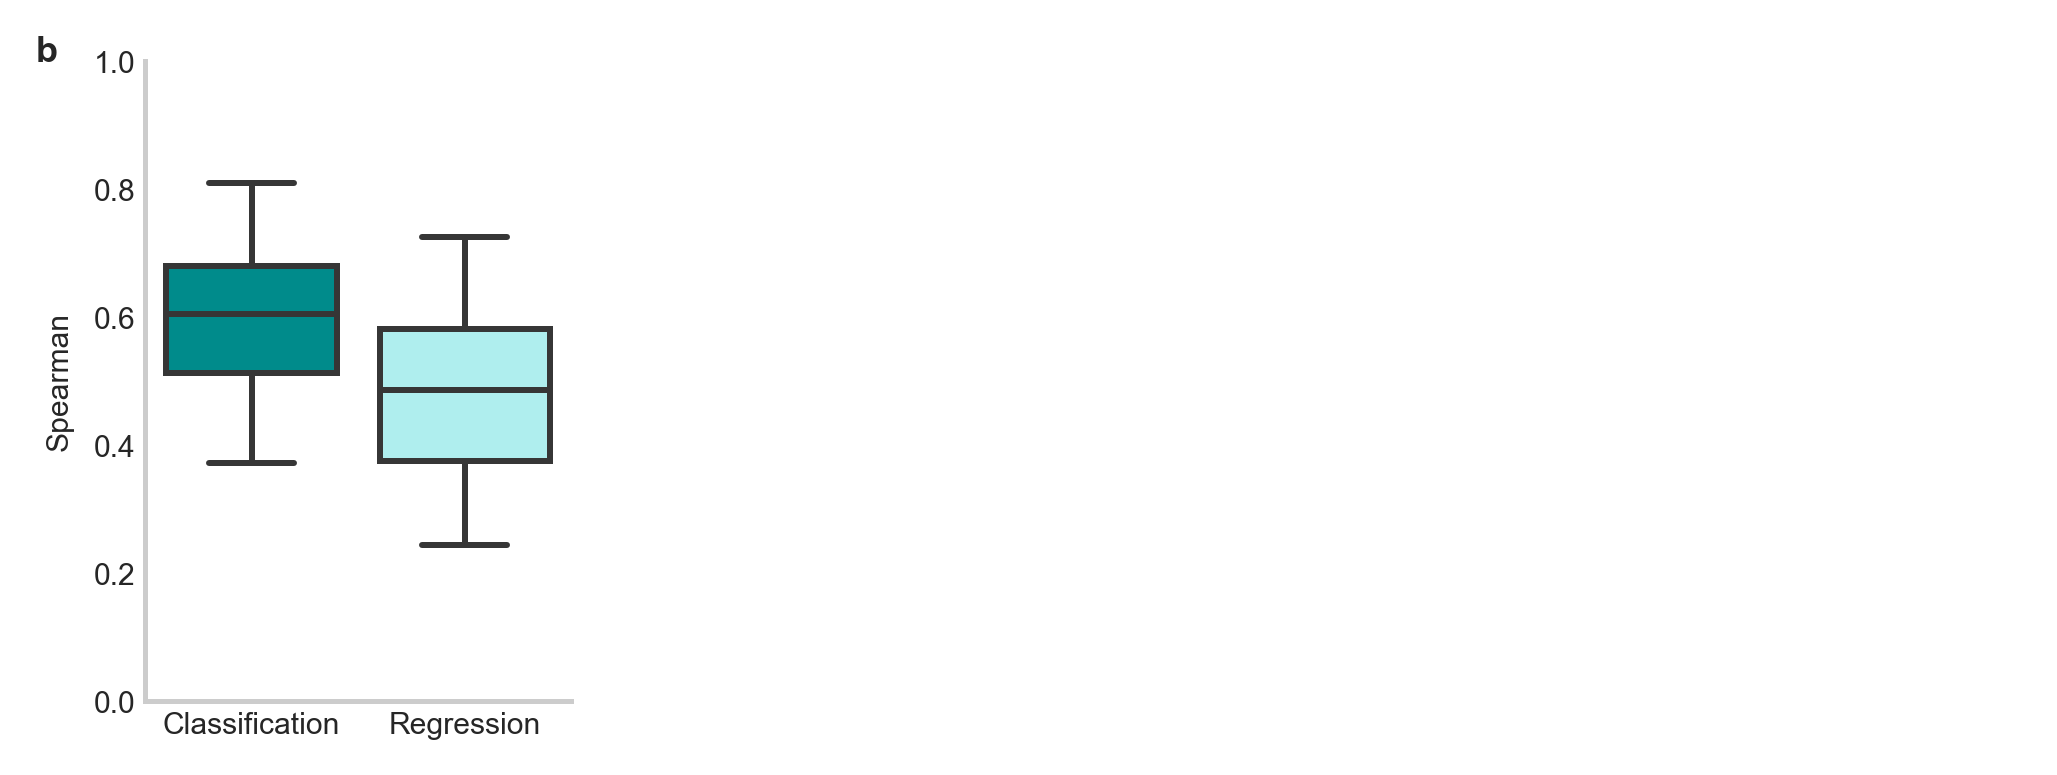

In [47]:
import matplotlib.patches as mpatches

df_plot = lmdf[lmdf['Metric'].str.contains('Spearman')
    & (lmdf['Split']=='LMO')]

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 3],
    #wspace=0.1,
    hspace=0.25,
)

ax_false = fig.add_subplot(gridspecs['gs_1-2'][0])
ax_true = fig.add_subplot(gridspecs['gs_1-2'][1])

sb.boxplot(data=df_plot, x='Metric', y='Value', ax=ax_false)
ax_false.grid(False)
sb.despine(ax=ax_false)
ax_false.set_ylabel('Spearman')

for i, art in enumerate(ax_false.artists):
    c = palette_tcrs['CMV']
    art.set_facecolor(c)
    if i%2==1:
        art.set_facecolor('paleturquoise')


ax_false.tick_params(axis='both', length=0, pad=2)
ax_false.set_xlabel(None, labelpad=1)
ax_false.set_xticklabels(['Classification', 'Regression'])
ax_false.set_ylim(0, 1)

ax_false.legend().remove()
ax_true.axis('off')

fig.text(0.08, 0.88, 'b', size='large', weight='bold')
fig.tight_layout()

In [48]:
df_plot.groupby(['Metric', 'Repertoire'])['Value'].mean()

Metric          Repertoire
Spearman        CMV           0.592091
Spearman_class  CMV           0.481882
Name: Value, dtype: float64

## Positionwise Testing

In [49]:
def compute_class_score(g):
    return pd.Series({
        'Accuracy': (metrics.accuracy_score(g['is_activated'], g['pred_bin'])),
    })

In [50]:
ppdf['pred_bin'] = ppdf['pred_prob'] > 0.5
df_acc = ppdf.query('features=="lmo"') \
        .groupby(['features', 'tcr', 'mut_pos']) \
        .apply(compute_class_score).reset_index()
#acc = acc.rename(columns={0: 'Accuracy'})
df_acc['Repertoire'] = 'CMV'
df_acc['mut_pos'] = df_acc['mut_pos'] + 1
df_acc.groupby('Repertoire')['Accuracy'].mean()

Repertoire
CMV    0.811696
Name: Accuracy, dtype: float64

<ipython-input-51-bb18da2a7af1>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


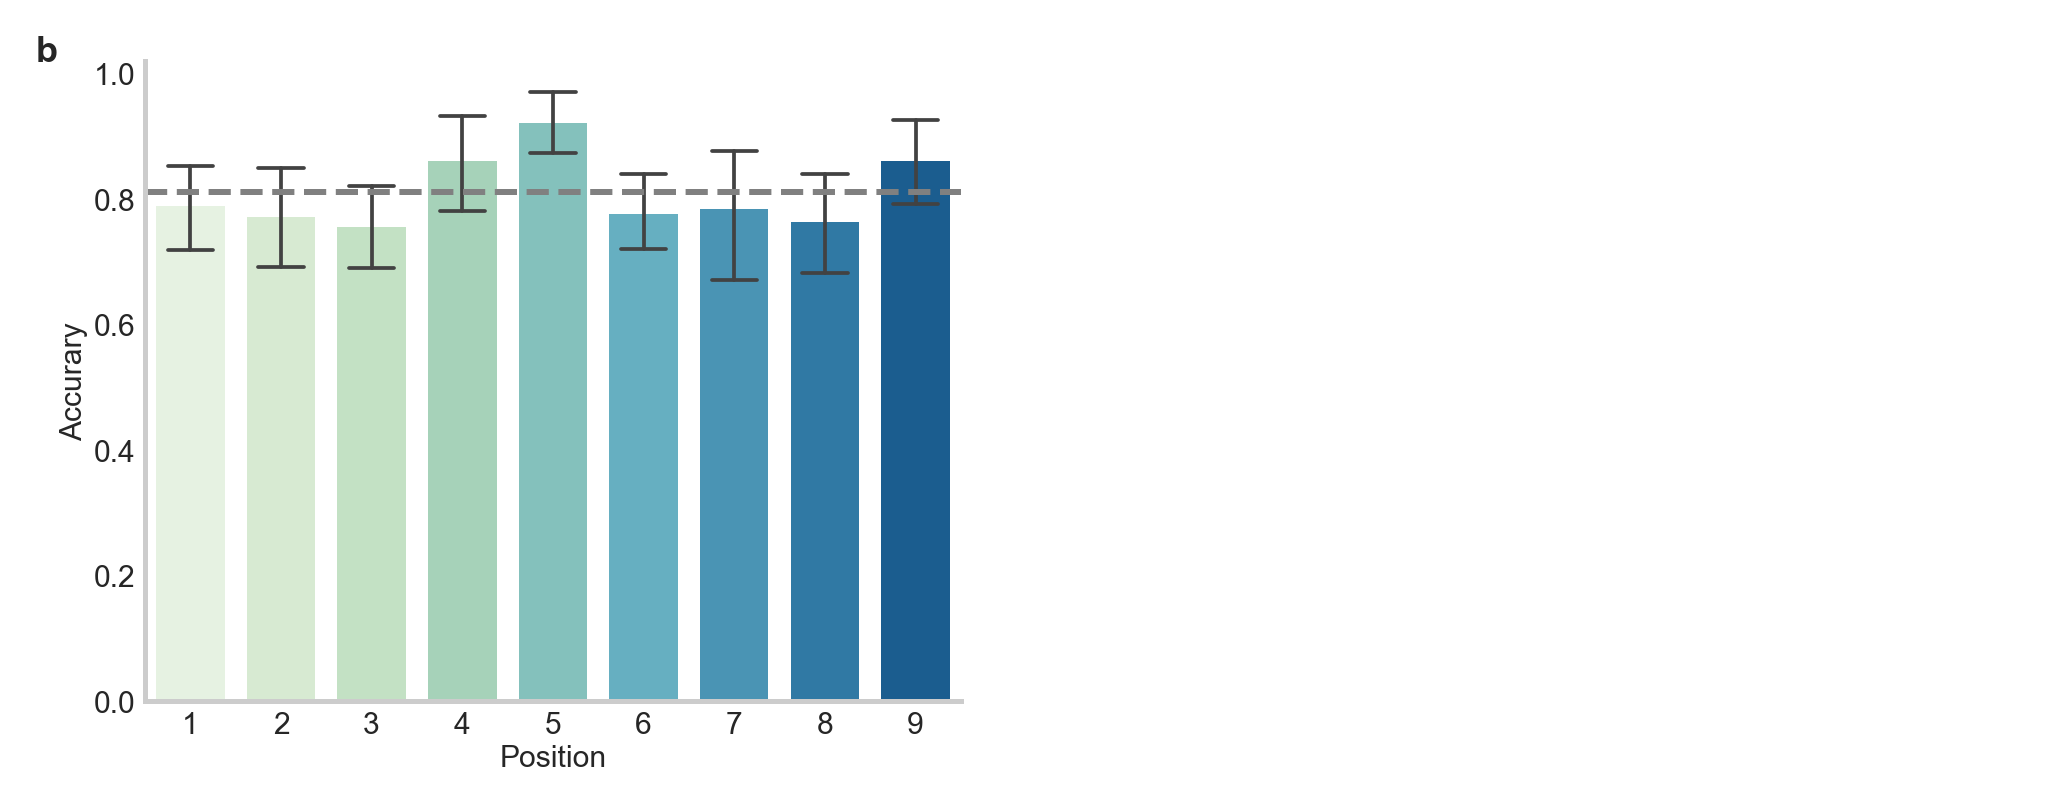

In [51]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3,
    #hspace=0.4,
)

ax = fig.add_subplot(gridspecs['gs_1-2'][0])
sb.barplot(data=df_acc, y='Accuracy', x='mut_pos', ax=ax, palette='GnBu', errwidth=0.75, capsize=0.5)
sb.despine(ax=ax)
ax.axhline(df_acc['Accuracy'].mean(), color='gray', linestyle='--')
ax.grid(False)
ax.set_ylabel('Accurary', labelpad=1)
ax.tick_params(axis='both', length=0, pad=2)
ax.set_xlabel('Position', labelpad=1)

ax_empty = fig.add_subplot(gridspecs['gs_1-2'][1])
ax_empty.axis('off')
fig.text(0.08, 0.88, 'b', size='large', weight='bold')
fig.tight_layout()

## Positionwise Accuracy through distance matric

In [52]:
def index_2_epitope(ind):
    base_epitope = 'NLVPMVATV'    
    pos = int(ind.split('_')[0])-1
    aminos = 'ACDEFGHIKLMNPQRSTVWY'.replace(base_epitope[pos], '')
    aa = ind.split('_')[1]
    epitope = base_epitope[:pos] + aa + base_epitope[pos+1:]
    return epitope
    
df_sim = data_cmv_norm[data_cmv_norm.index!='0_0'].copy()
df_sim['APL'] = df_sim.index.map(index_2_epitope)
df_sim['mut_pos'] = df_sim.index.str.split('_').str[0]
df_sim

,77_14,81_14,65_8,73_14,6_2,5_2,83_3,10_4,11_4,82_14,...,54_10,52_10,1_4,74_14,4_4,2_4,51_10,Activation,APL,mut_pos
1_A,86.138015,14.706419,73.088843,12.715299,35.904117,71.317427,42.852014,55.438596,59.504132,63.563564,...,50.668724,8.341759,31.287726,28.708221,47.715472,50.512164,40.327533,46.373655,ALVPMVATV,1
1_C,88.801453,4.263886,74.070248,46.048632,53.361126,73.029046,35.394257,67.368421,66.115702,60.710711,...,49.279835,37.462083,39.386318,41.550208,48.130841,50.256082,36.591607,51.591773,CLVPMVATV,1
1_D,51.089588,2.066828,63.171488,15.146910,27.305888,60.269710,23.512900,36.541353,39.411157,39.189189,...,24.948560,8.973711,3.762575,11.177435,23.883697,19.910371,11.412487,27.602658,DLVPMVATV,1
1_E,29.116223,1.259196,54.080579,11.043566,16.623241,46.784232,22.970539,14.085213,18.078512,35.585586,...,15.586420,6.658241,2.479879,8.462225,22.377985,15.941101,6.944729,19.797344,ELVPMVATV,1
1_F,86.380145,2.942802,44.163223,7.634245,59.770714,76.192946,4.754306,39.348371,44.834711,59.809810,...,52.057613,6.491405,2.917505,5.340772,45.950156,36.491677,34.953941,36.905673,FLVPMVATV,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_R,16.404358,28.807615,12.190083,16.058764,29.598749,18.672199,14.673913,22.556391,24.173554,5.115115,...,6.949588,11.476239,4.859155,8.814103,2.326064,6.370038,3.034800,12.597805,NLVPMVATR,9
9_S,9.412833,5.676353,4.096074,6.048632,33.454924,13.485477,14.456522,9.548872,13.946281,5.960961,...,7.042181,5.348837,3.435614,4.782051,2.019730,5.480154,3.254862,8.090795,NLVPMVATS,9
9_T,8.523002,4.183367,14.204545,5.126646,14.955706,7.059129,2.940217,4.962406,6.358471,2.792793,...,2.798354,4.934277,14.587525,3.474359,0.950156,4.238156,2.323439,5.729934,NLVPMVATT,9
9_W,12.348668,15.681363,8.672521,16.919959,13.757165,10.082988,1.831522,5.042607,6.813017,3.138138,...,2.602881,10.242669,14.185111,3.185897,1.947040,3.886044,2.134084,7.557219,NLVPMVATW,9


In [53]:
def aa_dif(base, apl):
    aa_ex = None
    for i, j in zip(base, apl):
        if i != j:
            return i, j
    raise ValueError
    
df_blosum = {
    'A': [ 4, -1, -2, -2,  0, -1, -1,  0, -2, -1, -1, -1, -1, -2, -1,  1,  0, -3, -2, 0],
    'R': [-1,  5,  0, -2, -3,  1,  0, -2,  0, -3, -2,  2, -1, -3, -2, -1, -1, -3, -2, -3],
    'N': [-2,  0,  6,  1, -3,  0,  0,  0,  1, -3, -3,  0, -2, -3, -2,  1,  0, -4, -2, -3],
    'D': [-2, -2,  1,  6, -3,  0,  2, -1, -1, -3, -4, -1, -3, -3, -1,  0, -1, -4, -3, -3],
    'C': [ 0, -3, -3, -3,  9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1],
    'Q': [-1,  1,  0,  0, -3,  5,  2, -2,  0, -3, -2,  1,  0, -3, -1,  0, -1, -2, -1, -2],
    'E': [-1,  0,  0,  2, -4,  2,  5, -2,  0, -3, -3,  1, -2, -3, -1,  0, -1, -3, -2, -2],
    'G': [ 0, -2,  0, -1, -3, -2, -2,  6, -2, -4, -4, -2, -3, -3, -2,  0, -2, -2, -3, -3],
    'H': [-2,  0,  1, -1, -3,  0,  0, -2,  8, -3, -3, -1, -2, -1, -2, -1, -2, -2,  2, -3],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3,  4,  2, -3,  1,  0, -3, -2, -1, -3, -1, 3],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3,  2,  4, -2,  2,  0, -3, -2, -1, -2, -1, 1],
    'K': [-1,  2,  0, -1, -3,  1,  1, -2, -1, -3, -2,  5, -1, -3, -1,  0, -1, -3, -2, -2],
    'M': [-1, -1, -2, -3, -1,  0, -2, -3, -2,  1,  2, -1,  5,  0, -2, -1, -1, -1, -1, 1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1,  0,  0, -3,  0,  6, -4, -2, -2,  1,  3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4,  7, -1, -1, -4, -3, -2],
    'S': [ 1, -1,  1,  0, -1,  0,  0,  0, -1, -2, -2,  0, -1, -2, -1,  4,  1, -3, -2, -2],
    'T': [ 0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  1,  5, -2, -2, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1,  1, -4, -3, -2, 11,  2, -3],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3,  2, -1, -1, -2, -1,  3, -3, -2, -2,  2,  7, -1],
    'V': [ 0, -3, -3, -3, -1, -2, -2, -3, -3,  3,  1, -2,  1, -1, -2, -2,  0, -3, -1, 4],
}
cols = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
df_blosum = pd.DataFrame(df_blosum, index=cols)

def blosum_dist(base, apl):
    old, new = aa_dif(base, apl)
    # high values => high similarity
    dist = df_blosum.loc[old, new]
    return dist

atchley_factors = {
    'A': [-0.591, -1.302, -0.733, 1.570, -0.146],
    'C': [-1.343, 0.465, -0.862, -1.020, -0.255],
    'D': [1.050, 0.302, -3.656, -0.259, -3.242],
    'E': [1.357, -1.453, 1.477, 0.113, -0.837],
    'F': [-1.006, -0.590, 1.891, -0.397, 0.412],
    'G': [-0.384, 1.652, 1.330, 1.045, 2.064],
    'H': [0.336, -0.417, -1.673, -1.474, -0.078],
    'I': [-1.239, -0.547, 2.131, 0.393, 0.816],
    'K': [1.831, -0.561, 0.533, -0.277, 1.648],
    'L': [-1.019, -0.987, -1.505, 1.266, -0.912],
    'M': [-0.663, -1.524, 2.219, -1.005, 1.212],
    'N': [0.945, 0.828, 1.299, -0.169, 0.933],
    'P': [0.189, 2.081, -1.628, 0.421, -1.392],
    'Q': [0.931, -0.179, -3.005, -0.503, -1.853],
    'R': [1.538, -0.055, 1.502, 0.440, 2.897],
    'S': [-0.228, 1.399, -4.760, 0.670, -2.647],
    'T': [-0.032, 0.326, 2.213, 0.908, 1.313],
    'V': [-1.337, -0.279, -0.544, 1.242, -1.262],
    'W': [-0.595, 0.009, 0.672, -2.128, -0.184],
    'Y': [0.260, 0.830, 3.097, -0.838, 1.512],
}

def atchley_dist(base, apl):
    old, new = aa_dif(base, apl)
    old = np.array(atchley_factors[old])
    new = np.array(atchley_factors[new])
    dist = np.linalg.norm(old-new)
    # max value = 9.04 => invert with 10 to change distance to similarity
    dist = 10 - dist
    return dist

df_sim['Blosum'] = df_sim['APL'].apply(lambda x: blosum_dist('NLVPMVATV', x))
df_sim['Atchley'] = df_sim['APL'].apply(lambda x: atchley_dist('NLVPMVATV', x))
df_sim

,77_14,81_14,65_8,73_14,6_2,5_2,83_3,10_4,11_4,82_14,...,1_4,74_14,4_4,2_4,51_10,Activation,APL,mut_pos,Blosum,Atchley
1_A,86.138015,14.706419,73.088843,12.715299,35.904117,71.317427,42.852014,55.438596,59.504132,63.563564,...,31.287726,28.708221,47.715472,50.512164,40.327533,46.373655,ALVPMVATV,1,-2,6.099541
1_C,88.801453,4.263886,74.070248,46.048632,53.361126,73.029046,35.394257,67.368421,66.115702,60.710711,...,39.386318,41.550208,48.130841,50.256082,36.591607,51.591773,CLVPMVATV,1,-3,6.511135
1_D,51.089588,2.066828,63.171488,15.146910,27.305888,60.269710,23.512900,36.541353,39.411157,39.189189,...,3.762575,11.177435,23.883697,19.910371,11.412487,27.602658,DLVPMVATV,1,1,3.497812
1_E,29.116223,1.259196,54.080579,11.043566,16.623241,46.784232,22.970539,14.085213,18.078512,35.585586,...,2.479879,8.462225,22.377985,15.941101,6.944729,19.797344,ELVPMVATV,1,0,7.064559
1_F,86.380145,2.942802,44.163223,7.634245,59.770714,76.192946,4.754306,39.348371,44.834711,59.809810,...,2.917505,5.340772,45.950156,36.491677,34.953941,36.905673,FLVPMVATV,1,-3,7.452253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_R,16.404358,28.807615,12.190083,16.058764,29.598749,18.672199,14.673913,22.556391,24.173554,5.115115,...,4.859155,8.814103,2.326064,6.370038,3.034800,12.597805,NLVPMVATR,9,-3,4.482537
9_S,9.412833,5.676353,4.096074,6.048632,33.454924,13.485477,14.456522,9.548872,13.946281,5.960961,...,3.435614,4.782051,2.019730,5.480154,3.254862,8.090795,NLVPMVATS,9,-2,5.094327
9_T,8.523002,4.183367,14.204545,5.126646,14.955706,7.059129,2.940217,4.962406,6.358471,2.792793,...,14.587525,3.474359,0.950156,4.238156,2.323439,5.729934,NLVPMVATT,9,0,5.948793
9_W,12.348668,15.681363,8.672521,16.919959,13.757165,10.082988,1.831522,5.042607,6.813017,3.138138,...,14.185111,3.185897,1.947040,3.886044,2.134084,7.557219,NLVPMVATW,9,-3,6.174932


In [54]:
tcrs = [el for el in df_sim.columns if el not in ['APL', 'Blosum', 'Atchley', 'mut_pos']]

content = {
    'tcr': [],
    'mut_pos': [],
    'Metric': [],
    'Accuracy': [],
}

for distance in ['Blosum', 'Atchley']:
    for pos in range(1, 10):
        tmp_pos = df_sim[df_sim['mut_pos']==str(pos)].copy()
        
        thresholds = [-20] + tmp_pos[distance].unique().tolist()
        tmp_pos[tcrs] = tmp_pos[tcrs] > 40
        
        max_t = -20
        max_acc = -99
        for t in thresholds:
            tmp_pos_pred = tmp_pos[distance]>t
            #print(t)
            #print(tmp_pos_pred)
            acc = np.sum((tmp_pos[tcrs].values == tmp_pos_pred.values[:, np.newaxis])) / (len(tmp_pos) * len(tcrs))
            #print(acc)
            if acc > max_acc:
                max_acc = acc
                max_t = t
        
        for tcr in tcrs:
            content['tcr'].append(tcr)
            content['mut_pos'].append(pos)
            content['Metric'].append(distance)
            
            tmp = df_sim[df_sim['mut_pos']==str(pos)][[tcr, distance]].copy()
            acc = np.sum((tmp[tcr]>40) == (tmp[distance]>max_t)) / len(tmp)
            content['Accuracy'].append(acc)

content = pd.DataFrame(content)
content.head(5)

,tcr,mut_pos,Metric,Accuracy
0,77_14,1,Blosum,0.842105
1,81_14,1,Blosum,0.052632
2,65_8,1,Blosum,0.947368
3,73_14,1,Blosum,0.368421
4,6_2,1,Blosum,0.684211


<ipython-input-55-93270e537beb>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Text(0.08, 0.88, 'b')

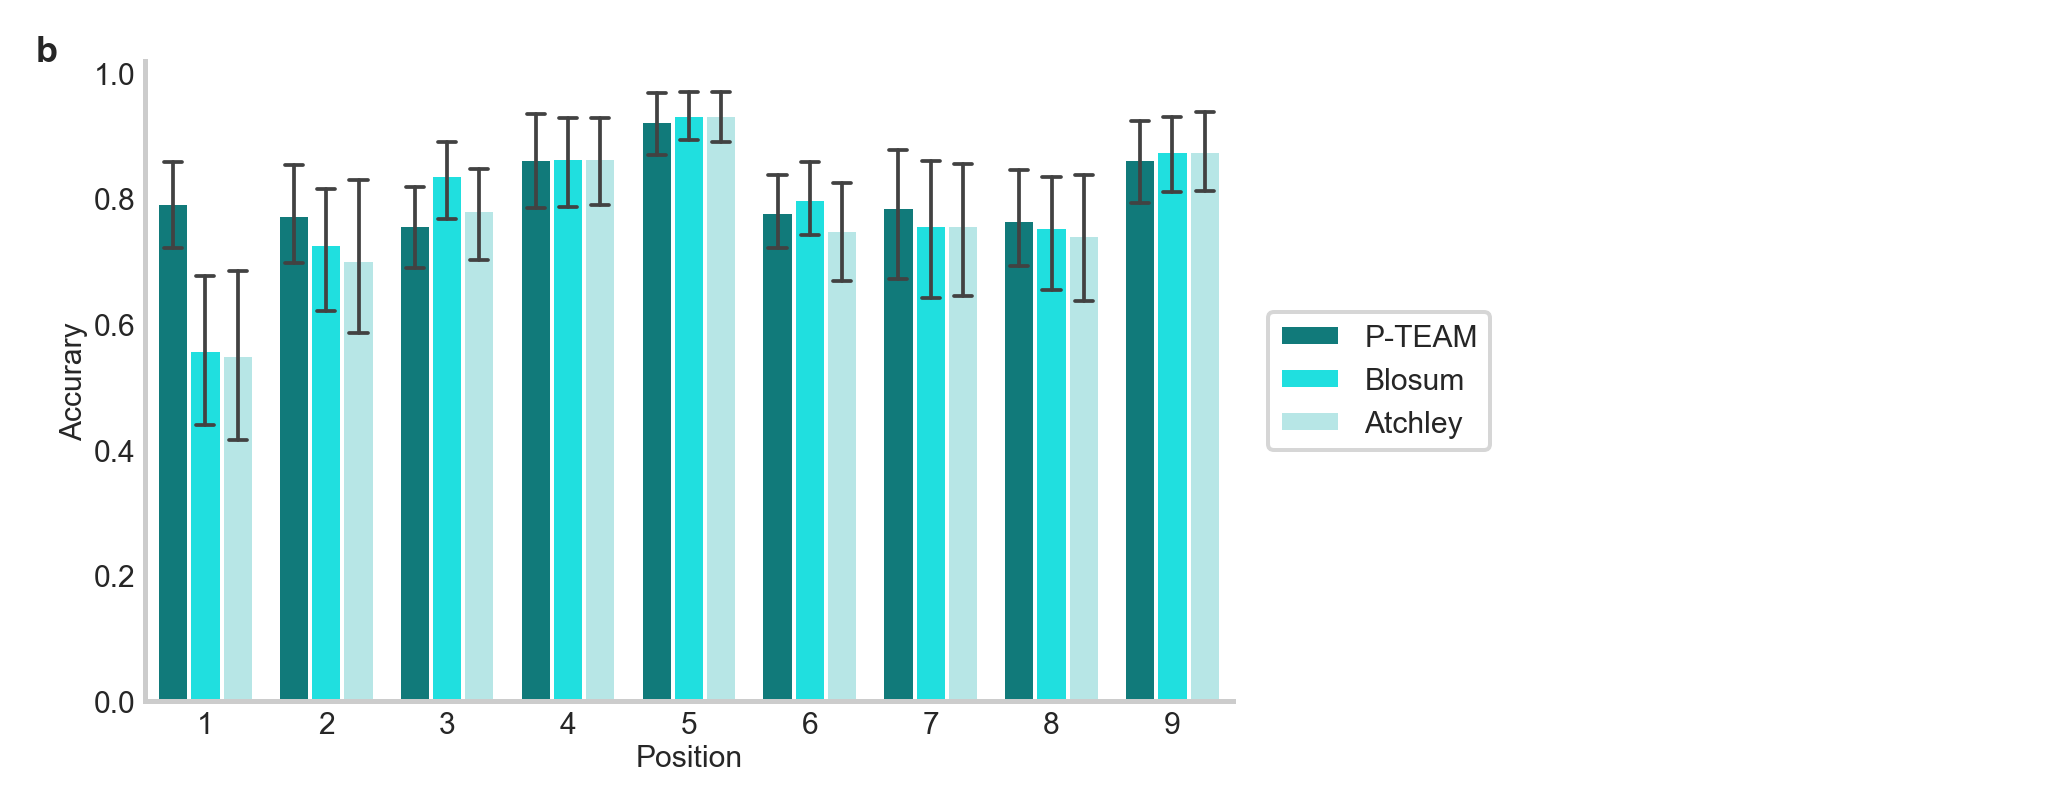

In [55]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.35), dpi=DPI)
gridspecs = {}
axes = {}

df_acc['Metric'] = 'P-TEAM'
df_dist_comp = pd.concat([df_acc, content])

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 1],
    wspace=0.3,
    #hspace=0.4,
)

ax = fig.add_subplot(gridspecs['gs_1-2'][0])
custom_palette = ['darkcyan', 'aqua', 'paleturquoise']
sb.barplot(data=df_dist_comp, y='Accuracy', x='mut_pos', hue='Metric', ax=ax, 
           palette=custom_palette, errwidth=0.75, capsize=0.15)
sb.despine(ax=ax)
ax.set_xlabel('Position')
ax.grid(False)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
ax.set_ylabel('Accurary', labelpad=1)
ax.tick_params(axis='both', length=0, pad=2)
ax.set_xlabel('Position', labelpad=1)

ax_empty = fig.add_subplot(gridspecs['gs_1-2'][1])
ax_empty.axis('off')
    
#legend_patches = [mpatches.Patch(color=palette_tcrs[name], label=name) for name in reps]
#axes[1].legend(handles=legend_patches, ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
    
fig.tight_layout()
fig.text(0.08, 0.88, 'b', size='large', weight='bold')
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.pdf', dpi=DPI, bbox_inches='tight')
#fig.savefig('figures/manuscript_supp_poswiseAccVsDistance.png', dpi=DPI, bbox_inches='tight')

In [56]:
df_dist_comp.groupby(['Metric'])['Accuracy'].mean()

Metric
Atchley    0.772765
Blosum     0.789474
P-TEAM     0.811696
Name: Accuracy, dtype: float64

In [57]:
df_dist_comp.groupby(['Metric', 'mut_pos'])['Accuracy'].mean()

Metric   mut_pos
Atchley  1          0.551378
         2          0.701754
         3          0.781955
         4          0.864662
         5          0.932331
         6          0.749373
         7          0.756892
         8          0.741855
         9          0.874687
Blosum   1          0.558897
         2          0.726817
         3          0.837093
         4          0.864662
         5          0.932331
         6          0.799499
         7          0.756892
         8          0.754386
         9          0.874687
P-TEAM   1          0.792105
         2          0.773684
         3          0.757895
         4          0.863158
         5          0.923684
         6          0.778947
         7          0.786842
         8          0.765789
         9          0.863158
Name: Accuracy, dtype: float64